## Introduction

Spotify is a music streaming service that provides millions of songs towards users that are able to be stored in playlists. A playlist is a collection of songs categorized by how a user would like. Typically, playlists are formed around a certain mood or genre where songs in that playlist will convey a similar feeling. What makes Spotify stand out is its ability to generate custom playlists that are generated based on what the users listen to. Typically, these playlists include a good portion of songs users have listened to and some songs that a user may have never listened to, but are suggested based on how related that song is to the playlist. This raises the question on how Spotify finds these songs that can accurately fit in a playlist, or how a custom playlist can so accurately depict a mood or a genre. This project explores this question using different techniques like logistic regression and K-nearest neighbors to analyze how songs can be accurately classified.

## Code Setup

In [62]:
# import necessary packages
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

## Logistic Regression

Logistic regression is a model intended to output binary classification. It takes an input of parameters and with an optimized weight, will be applied to a sigmoid function to return a value between 0 and 1. The sigmoid is defined as $\sigma(a) = \frac{1}{1 + e^{-a}}$. The input of the sigmoid function will be an an altered version of the parameters $w^tx + b$ where $w$ are the weights, $x$ are the input parameters, and $b$ is the bias term. In total, the logstic regression will look like: 
$\sigma(w^tx + b) = \frac{1}{1 + e^{-w^tx - b}}$

The weights and bias are found by minimizing its loss function, defined by: $\mathbb{L}_{w,b} = \sum_{n=1}^N[ -y_n log(f(x_n)) - (1 - y_n) log(1 - f(x_n))]$ Directly finding the solution to this optimization problem is nearly impossible so some form of gradient descent must be applied to find the optimal parameters. The gradients for $w$ and $b$ can be found with $\nabla_w \mathbb{L}(x_n) = (\sigma(w^tx_n +b) - y_n)x_n$ and $\nabla_b \mathbb{L}(x_n) = \sigma(w^tx_n + b) - y_n$. A mini-batch SGD algorithm will be implemented to optimize accuracy and computational costs.

In [5]:
#logistic regression function
def logreg(z):
    #denom = 1 + np.exp(-z)
    return 1 / (1 + np.exp(-z))

#gradient weight error
def gradient_error(X, y, w, n, b):
    return (logreg((w.T @ X[n]) + b) - y[n]) * X[n]

#gradient bias error
def gradient_bias(X, y, w, n, b):
    return (logreg((w.T @ X[n]) + b) - y[n])

#minibatch SGD algorithm
def minibatch(X, y, iter = 1000, step = 0.0001, batchsize = 32):
    #initialize w0
    w = np.random.randn(X.shape[1])
    b = np.random.randn(1)

    for i in range(iter):
        #set the error term from the minibatch
        batch = np.random.randint(0, X.shape[0] - 1, batchsize)
        #initialize weight and bias
        target = 0
        btar = 0
        for j in batch:
            target += gradient_error(X, y, w, j, b) #update error on summation of batch
            btar += gradient_bias(X, y, w, j, b)

        #average weight and bias
        target /= batchsize
        btar /= batchsize

        #update weights and bias
        w = w - (step * target)
        b = b - (step * btar)

    return w, b

## Data Setup

The dataset given derives from custom made playlist in which it contains information of the parameters that describe the song (artist, tempo, energy, valence, etc).

In [87]:
#load all datasets to use for project
rap = pd.read_csv("rap_playlist.csv")
prog = pd.read_csv("progpop_playlist.csv")
sleep = pd.read_csv("sleep_playlist.csv")
nature = pd.read_csv("nature.csv")
miserable = pd.read_csv("miserable.csv")
primas = pd.read_csv("primas.csv")
shoegaze = pd.read_csv("shoegaze.csv")
indie_folk = pd.read_csv("indie_folk.csv")

In [98]:
rap.head()

,#,Song,Artist,Popularity,BPM,Genres,Parent Genres,Album,Album Date,Time,...,Speech,Live,Loud (Db),Key,Time Signature,Added At,Spotify Track Id,Album Label,Camelot,ISRC
0,1,NEW MAGIC WAND,"Tyler, The Creator",81,140,"hip hop, rap",Hip Hop,IGOR,2019-05-17,03:15,...,10,60,-5,F Minor,4,2023-04-29,0fv2KH6hac06J86hBUTcSf,Columbia,4A,USQX91901115
1,2,She Knows This,Kid Cudi,48,166,"hip hop, ohio hip hop, pop rap, rap",Hip Hop,Man On The Moon III: The Chosen,2020-12-11,03:36,...,0,30,-8,F#/G♭ Minor,4,2023-04-29,1xzUQMiCoY5pdego0pHMeV,Republic Records,11A,USUM72023837
2,3,Sept. 16,Kid Cudi,46,141,"hip hop, ohio hip hop, pop rap, rap",Hip Hop,Man On The Moon III: The Chosen,2020-12-11,04:09,...,0,10,-7,E Minor,4,2023-04-29,3Uw2se3aQU1UFrpRBvBnB4,Republic Records,9A,USUM72023846
3,4,Alive (Nightmare),"Kid Cudi,Ratatat",54,102,"hip hop, ohio hip hop, pop rap, rap, brooklyn ...","Rock, Hip Hop, Pop",Man On The Moon: The End Of Day (Deluxe),2009-01-01,04:06,...,0,20,-5,F#/G♭ Minor,4,2023-04-29,3HG3QFERdP3Q1b6VGahwWs,Kid Cudi/Universal Records,11A,USUM70981728
4,5,Backseat Freestyle,Kendrick Lamar,51,78,"conscious hip hop, hip hop, rap, west coast rap",Hip Hop,"good kid, m.A.A.d city",2012-00-00,03:32,...,30,20,-8,C♯/D♭ Major,4,2023-04-29,6fAyRZ0GHuuvSOEIOwi58N,Aftermath,3B,USUM71210777


The dataset contains string entries that can't be used for analysis. Furthermore, the song id and popularity are removed as it clearly has no correlation to the classification of a song. The parameters that will be used to predict song classifications are BPM, dance, energy, acoustic, instrumental, happy, speech, liveliness, loudness (Db), and time signature.

In [11]:
def numfilter(X):
    intcol = np.array(X.select_dtypes(include = 'int')) #subset to only int values
    intcol = intcol[:, 2:10] #removes songid and popularity
    return intcol

Prepare the model for train test split

In [12]:
def modelprep(a, b): #stacks the two playlists for testing and the output section corresponding to playlist
    a = numfilter(a)
    b = numfilter(b)
    X = np.row_stack((a, b))
    y = np.concatenate((np.zeros(a.shape[0]), np.ones(b.shape[0])))
    return X, y

#combines rap and prog
X, y = modelprep(rap, prog)

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 32)

## Cooking the code

With the ingredients prepared, the kitchen is ready to cook. In this example, a ra and a progressive pop playlist will be used. Start by training the model:

In [20]:
w, b = minibatch(X_train, y_train, iter = 5000, step = 0.0001, batchsize = 16)

Calculate the prediction output based on the trained weights and bias

In [21]:
def pred(X, w, b):
    output = X @ w + b
    output = logreg(output) #logistic sigmoid 
    output = (output >= 0.5).astype(int).reshape(X.shape[0]) #round probabilities to classify
    return output

#apply the prediction to the testing dataset
X_test_pred = pred(X_test, w, b)

With the predicted outputs, the accuracy will be checked

In [94]:
def accuracy(pred, res):
    return (sum(pred == res)) / (len(pred))
    
log_ac = accuracy(X_test_pred, y_test) 
print(f"Accuracy = {log_ac}")


Accuracy = 0.8793103448275862


An accuracy of about 88% is achieved, this means that 88% of the songs in the testing dataset have been accurately classified.

## KNN 

K-Nearest Neighbors (or KNN) is a classification technique similar to logistic regression, but allows for more than two classifications to occur. The model set up with given clusters that belong to a certain class and predicts classification based on the labels of the k-nearest points. The distance is calculated using a given distance measure, typically the 2-norm: $||x^* - x_i||_2$ where $x^*$ is the input being labelled and $x_i$ a given classified point. It follows similarly to K-means classification except the clusters are already labelled. 

Four genres, rap, progressive pop, shoegaze, and indie folk will be used to test the accuracy of KNN. Here is a tested KNN model with a given k-value.

In [91]:
def knn_accuracy(T, ts = 0.25, k = 7):
    #create full dataframe
    T_all = pd.concat(T, axis=0, ignore_index=True)
    T_all = numfilter(T_all)

    #true classification
    y = np.concatenate([np.repeat(i + 1, len(df)) for i, df in enumerate(T)])

    #train test split
    X_train, X_test, y_train, y_test = train_test_split(T_all, y, test_size = ts, random_state = 42)

    #train knn using cross validation
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    #accuracy
    acc = knn.score(X_test, y_test)
    
    return acc


    
T2 = [rap, prog, shoegaze, indie_folk]
acu2 = knn_accuracy(T2, k= 14)
acu2

0.768

The model seems to be showing about 76.8% accuracy, meaning about 76.8% of the songs in the testing dataset are correctly labelled.

## Optimal k-value

The choice of k can improve the accuracy of the result. Below is a graph of the accuracy of the model throughout various k-values:

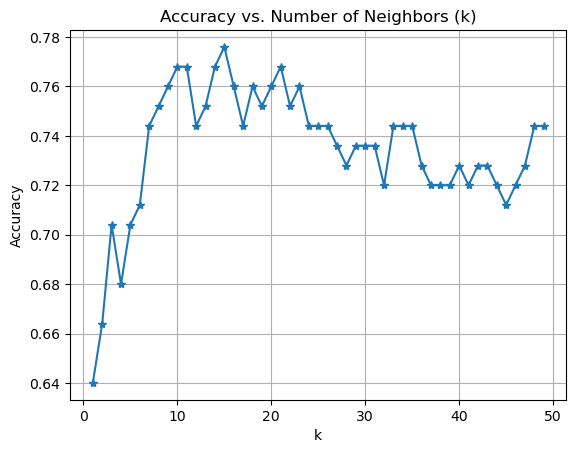

In [93]:
k_val = range(1,50)
accuracy_output = []

for i in k_val:    
    accuracy_output.append(knn_accuracy(T2, k = i))

# Plotting the accuracy for each k-value
plt.plot(k_val, accuracy_output, marker='*')
plt.title('Accuracy vs. Number of Neighbors (k)')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## Logistic Regression vs KNN

Comparing logstic regression to KNN in a binary case. Going back to the original example with rap and progressive pop:

In [96]:
prog_rap = [rap, prog]
acu = []
for i in k_val:
    acu.append(knn_accuracy(prog_rap, k = i))

print(f"KNN Accuracy = {np.max(acu)}")
print(f"Logistic Regression Accuracy = {log_ac}")

KNN Accuracy = 0.7758620689655172
Logistic Regression Accuracy = 0.8793103448275862


The logistic regression model appears to function better. This may be explained as the logistic regression is a parametric model while KNN is a non-parametric model. The logistic regression model was trained while KNN used metrics already given. 

## Conclusion

Spotify songs can roughly be classified based on its metrics. In a binary case, a song can be classified using logistic regression, where the model is trained using mini-batch SGD to minimize the loss of the weight and bias. In a more complicated case, KNN can be used to classify a song under multiple labels. By calculating the k-closest songs and finding the majority label, a song can be classified towards that playlist. KNN seems to work less efficiently as it produces a lower accuracy than logistic regression and is computationally more expensive, however, logistic regression is limited to two classifications. These models can be applied to efficiently classify a song towards a genre or mood. Through this, new songs can be suggested to given playlists that a user has made. 

## References

- “Spotify Playlist Analyzer.” Chosic, 12 Aug. 2024, www.chosic.com/spotify-playlist-analyzer/?plid=5ysKGDUuMFHXRddbldy1ZW. 
- Thomas, Nathan. “Using K-Nearest Neighbours to Predict the Genre of Spotify Tracks.” Medium, Towards Data Science, 9 May 2020, towardsdatascience.com/using-k-nearest-neighbours-to-predict-the-genre-of-spotify-tracks-796bbbad619f.
